/tmp/ipykernel_42705/2746048040.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(model_path, map_location=device))


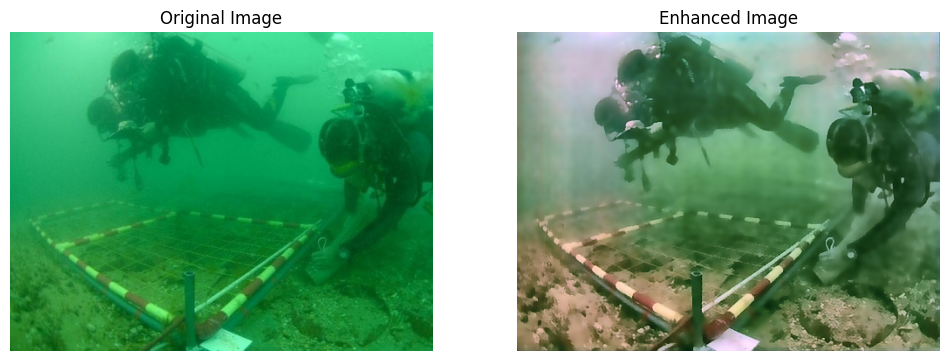

Enhanced image saved as 'enhanced_image.jpg'


In [11]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image, ImageEnhance
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F
# Define UNetDown and UNetUp classes (same as provided)
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, bn=True):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if bn: layers.append(nn.BatchNorm2d(out_size, momentum=0.8))
        layers.append(nn.LeakyReLU(0.2))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size):
        super(UNetUp, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_size, momentum=0.8),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, skip_input):
        x = self.model(x)

        # Ensure spatial size matches skip_input
        if x.size(2) != skip_input.size(2) or x.size(3) != skip_input.size(3):
            x = F.interpolate(x, size=(skip_input.size(2), skip_input.size(3)), mode='bilinear', align_corners=True)

        x = torch.cat((x, skip_input), 1)  # Concatenate along channel dim
        return x

# Define Generator
class GeneratorFunieGAN(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorFunieGAN, self).__init__()
        self.down1 = UNetDown(in_channels, 32, bn=False)
        self.down2 = UNetDown(32, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 256)
        self.down5 = UNetDown(256, 256, bn=False)
        self.up1 = UNetUp(256, 256)
        self.up2 = UNetUp(512, 256)
        self.up3 = UNetUp(512, 128)
        self.up4 = UNetUp(256, 32)
        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(64, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        u1 = self.up1(d5, d4)
        u2 = self.up2(u1, d3)
        u3 = self.up3(u2, d2)
        u4 = self.up4(u3, d1)
        return self.final(u4)

# Load trained generator model
def load_generator(model_path, device):
    generator = GeneratorFunieGAN().to(device)
    generator.load_state_dict(torch.load(model_path, map_location=device))
    generator.eval()
    return generator

# Preprocess input image
def preprocess_image(image_path, device):
    image = Image.open(image_path).convert("RGB")
    original_size = image.size  # Save original size (width, height)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    image = transform(image).unsqueeze(0).to(device)
    return image, original_size



# Convert output tensor to image
def tensor_to_image(tensor, original_size):
    tensor = tensor.squeeze(0).detach().cpu()
    tensor = (tensor + 1) / 2  # Rescale to [0, 1]
    image = transforms.ToPILImage()(tensor)
    
    # Resize back to original size
    image = image.resize(original_size, Image.BICUBIC)
    return image

# Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
def apply_clahe(image):
    image_cv = np.array(image)
    lab = cv2.cvtColor(image_cv, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    limg = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return Image.fromarray(enhanced_img)

# Apply White Balance Correction
def white_balance(image):
    image_cv = np.array(image)
    result = cv2.cvtColor(image_cv, cv2.COLOR_RGB2LAB)
    avg_a = np.mean(result[:, :, 1])
    avg_b = np.mean(result[:, :, 2])
    
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    
    result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
    return Image.fromarray(result)

# Apply Bilateral Filtering for Denoising
def denoise_image(image):
    image_cv = np.array(image)
    denoised = cv2.bilateralFilter(image_cv, d=9, sigmaColor=75, sigmaSpace=75)
    return Image.fromarray(denoised)

# Apply Sharpening
def sharpen_image(image):
    enhancer = ImageEnhance.Sharpness(image)
    return enhancer.enhance(2.0)

# Enhance image using generator and additional enhancements
def enhance_image(generator, image_path, device):
    input_image, original_size = preprocess_image(image_path, device)
    
    with torch.no_grad():
        output_image = generator(input_image)
    
    enhanced_image = tensor_to_image(output_image, original_size)  # Restore original size
    
    # Apply additional enhancements
    enhanced_image = apply_clahe(enhanced_image)
    enhanced_image = white_balance(enhanced_image)
    enhanced_image = denoise_image(enhanced_image)
    enhanced_image = sharpen_image(enhanced_image)
    
    return enhanced_image

# Main function
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator_path = "model/funie_generator.pth"  # Update with correct path
    image_path = "raw-890/105_img_.png"  # Update with your image
    
    generator = load_generator(generator_path, device)
    enhanced_image = enhance_image(generator, image_path, device)
    
    # Display original and enhanced images
    original_image = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    ax[1].imshow(enhanced_image)
    ax[1].set_title("Enhanced Image")
    ax[1].axis("off")
    plt.show()
    
    # Save enhanced image
    enhanced_image.save("enhanced_image.jpg")
    print("Enhanced image saved as 'enhanced_image.jpg'")

if __name__ == "__main__":
    main()
 

In [1]:
pip install scikit-image matplotlib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


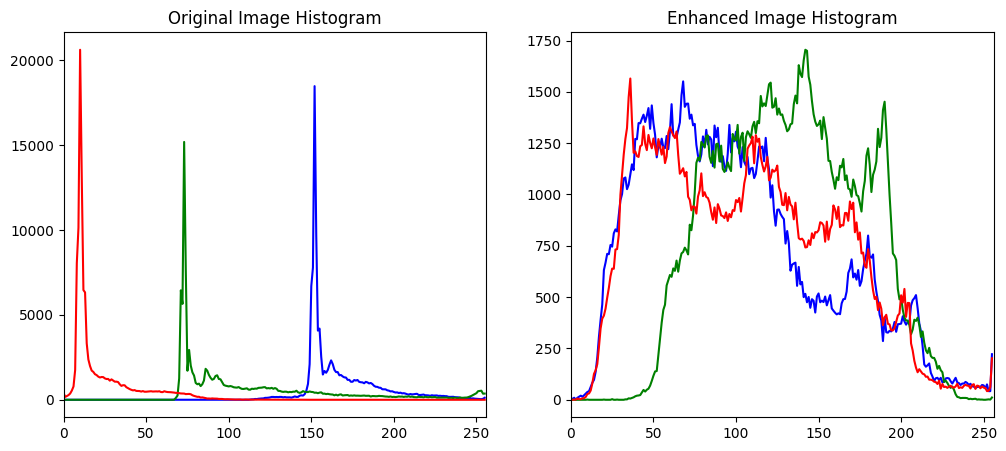

In [14]:
def plot_histograms(original_image, enhanced_image):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for i, (image, title) in enumerate(zip([original_image, enhanced_image], ["Original", "Enhanced"])):
        if isinstance(image, str):  # If image is a file path, load it
            image = Image.open(image).convert("RGB")

        img_np = np.array(image, dtype=np.uint8)  # Convert to NumPy array
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)  # Convert RGB → BGR (for OpenCV)

        for j, color in enumerate(["b", "g", "r"]):  # OpenCV uses BGR format
            hist = cv2.calcHist([img_np], [j], None, [256], [0, 256])
            axes[i].plot(hist, color=color)

        axes[i].set_title(f"{title} Image Histogram")
        axes[i].set_xlim([0, 256])

    plt.show()

# Example Usage:
original_image = Image.open(image_path).convert("RGB")  
enhanced_image = Image.open("enhanced_image.jpg").convert("RGB")  # Ensure enhanced image is loaded

plot_histograms(original_image, enhanced_image)
